In [72]:
import numpy as np
import pandas as pd
import random
import os
import json 

import algo
import attack

import torch
rand_seed=42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

import matplotlib.pyplot as plt



In [202]:
raw_data_path = '../datasets/dataset_purchase'
raw_data = pd.read_csv(raw_data_path)
y=raw_data['63']
X_raw =raw_data.drop('63', axis=1)
y_raw =  y.replace(100, 0)
print('Dataset: ', raw_data_path)
print('Classes in classification task: ', y.nunique())
n_classes = y.nunique()

Dataset:  ../datasets/dataset_purchase
Classes in classification task:  100


In [204]:
from torch import nn, optim

class Net_attack(nn.Module):

    def __init__(self, h_neurons, do, input_size):
        super(Net_attack, self).__init__()
        self.input_size = input_size
        self.h_neurons = h_neurons
        self.do = do
        self.fc1 = nn.Linear(input_size, h_neurons)
        self.fc2 = nn.Linear(h_neurons, 2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(do)
        self.softmax = nn.Softmax(dim=1)   

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.softmax(x)
        return x

def test_mi_attack(attack_models, target_model, x_target_train, y_target_train, x_target_test, y_target_test):
    
    results = {}
    at_acc = []
    at_rec = []
    at_pre = []
    for am in attack_models:
        a_model = attack_models[am] 
        attack_acc, attack_pre, attack_rec = attack.mi_attack_test(target_model, a_model, x_target_train, y_target_train, x_target_test, y_target_test)
        at_acc.append(attack_acc)
        at_pre.append(attack_pre)
        at_rec.append(attack_rec)
    results['attack_acc_mean'] = np.mean(at_acc)
    results['attack_acc_std'] = np.std(at_acc)
    results['attack_pre_mean'] = np.mean(at_pre)
    results['attack_pre_std'] = np.std(at_pre)
    results['attack_rec_mean'] = np.mean(at_rec)
    results['attack_rec_std'] = np.std(at_rec)
    
    return results

In [5]:
path = 'mia'
ams = {}
for r,d,f in os.walk(path):
    for file in f:
        if "best_mi_model" in file:
            ams[file] = Net_attack(h_neurons=64, do=0, input_size=200)
            ams[file] = torch.load(r+'/'+file)      

In [6]:
a_model = ams['best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-05_aepoch500']

In [7]:
x_target_train, y_target_train, x_target_test, y_target_test = attack.data_shuffle(rand_seed, X_raw, y_raw)
target_model = algo.LogisticRegression_DPSGD()
target_model.n_classes = 100
target_model.theta = np.load('tm/rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model.npy')
target_model.evaluate(x_target_train, y_target_train, acc=True)
target_model.evaluate(x_target_test, y_target_test, acc=True)
    

The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %


/Users/anastasia/Documents/Projects/dp_fl/attack.py:148: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/Users/anastasia/Documents/Projects/dp_fl/attack.py:150: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


0.5402

In [8]:
attack_acc, attack_pre, attack_rec = attack.mi_attack_test(target_model, a_model, x_target_train, y_target_train, x_target_test, y_target_test)

In [90]:
path = 'out_DP'
tms_params = {}
tms = {}
for r,d,f in os.walk(path):
    for file in f:
        if '.npy' in file:
            tms[file.replace('.npy','')] = np.load(path+'/'+file)
        elif '.json' in file:
            with open(path+'/'+file) as json_file:
                tms_params[file.replace('params.json','')]= json.load(json_file)
            


In [91]:
for key in tms:
    if 'attack_acc_mean' in tms_params[key]:
        continue
    target_model.theta = tms[key]
    at_acc = []
    at_rec = []
    at_pre = []
    for am in ams:
        a_model = ams[am] 
        attack_acc, attack_pre, attack_rec = attack.mi_attack_test(target_model, a_model, x_target_train, y_target_train, x_target_test, y_target_test)
        at_acc.append(attack_acc)
        at_pre.append(attack_pre)
        at_rec.append(attack_rec)
    tms_params[key]['attack_acc_mean'] = np.mean(at_acc)
    tms_params[key]['attack_acc_std'] = np.std(at_acc)
    tms_params[key]['attack_pre_mean'] = np.mean(at_pre)
    tms_params[key]['attack_pre_std'] = np.std(at_pre)
    tms_params[key]['attack_rec_mean'] = np.mean(at_rec)
    tms_params[key]['attack_rec_std'] = np.std(at_rec)

In [92]:
for key in tms_params:
    with open(f'out_dp/{key}params.json', 'w') as file:
        json.dump(tms_params[key], file)

In [93]:
l2_reg_res = {}
for key in tms_params:
    l2_reg = float(key[key.find('_reg')+4:key.find('_DPFalse')])
    eps = float(key[key.find('_outEps')+7:])
    if l2_reg not in l2_reg_res:
        l2_reg_res[l2_reg] = {}
    l2_reg_res[l2_reg][eps] = tms_params[key]

In [299]:
sort_keys = list(l2_reg_res.keys())
sort_keys.sort()
sort_keys

[1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.0005,
 0.001,
 0.005,
 0.01,
 0.05,
 0.1,
 1.0,
 10.0]

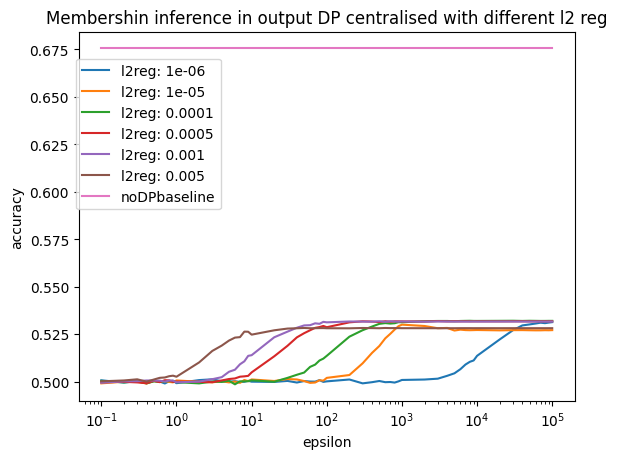

In [301]:
for l2 in sort_keys:
    if l2 not in l2_best:
        continue

    df = pd.DataFrame.from_dict(l2_reg_res[l2], orient='index')
    df = df.sort_index(ascending=True)
#     plt.errorbar(df.index, df['attack_acc_mean'], df['attack_acc_std'], label=f'l2reg: {l2}')  
    plt.plot(df.index, df['attack_acc_mean'], label=f'l2reg: {l2}')

plt.plot([df.index[0], df.index[-1]],[0.6755911111111111,0.6755911111111111], label='noDPbaseline')
plt.legend(loc='lower right', bbox_to_anchor=(0.3, 0.5))
plt.xlabel('epsilon')
plt.ylabel('accuracy')   
plt.xscale('log')
plt.title('Membershin inference in output DP centralised with different l2 reg')
plt.savefig('figures/outputDP_l2_best_Membership_Inference_with_baseline.png')

In [ ]:
data_save = {}
for l2 in l2_reg_res:
    df = pd.DataFrame.from_dict(l2_reg_res[l2], orient='index')
    df = df.sort_index(ascending=True)
#     plt.errorbar(df.index, df['attack_acc_mean'], df['attack_acc_std'], label=f'l2reg: {l2}')  
    x = df.index 
    data_save[f'{l2}l2_attack_acc_mean'] = df['attack_acc_mean']
    data_save[f'{l2}l2_attack_acc_std'] = df['attack_acc_std']
    data_save[f'{l2}l2_attack_pre_mean'] = df['attack_pre_mean']
    data_save[f'{l2}l2_attack_pre_std'] = df['attack_pre_std']
    data_save[f'{l2}l2_attack_rec_mean'] = df['attack_rec_mean']
    data_save[f'{l2}l2_attack_rec_std'] = df['attack_rec_std']

# data_save['epsilon'] 
d = pd.DataFrame.from_dict(data_save)
d.index = d.index.rename('epsilon')
d.to_csv('figures/outputDP_Membership_Inference_train_test_lambda_epsilon_all.csv')

In [119]:
#with Baseline

In [172]:
x = [1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.0005,
 0.001,
 0.005,
 0.01,
 0.05,
 0.1,
 1.0,
 10.0]

In [173]:
attack_acc = [0.6845888888888889,
 0.6847722222222221,
 0.684761111111111,
 0.6597883333333333,
 0.68535,
 0.6845527777777778,
 0.6832583333333334,
 0.6558361111111112,
 0.5992722222222223,
 0.5009250000000001,
 0.5002194444444444,
 0.5001083333333333,
 0.500125]

In [174]:
base_data = pd.DataFrame({'l2': x,'attack_acc': attack_acc})

In [175]:
base_data.isin({'l2': l2_best})
df2 = base_data.query('l2 in @l2_best')

In [176]:
np.mean(df2['attack_acc'])

0.6755911111111111

In [177]:
l2_best = [1e-06, 1e-05,0.0001,0.0005,0.001,0.005]


In [179]:
base_data.loc[base_data['l2']==0.005]

,l2,attack_acc
7,0.005,0.655836


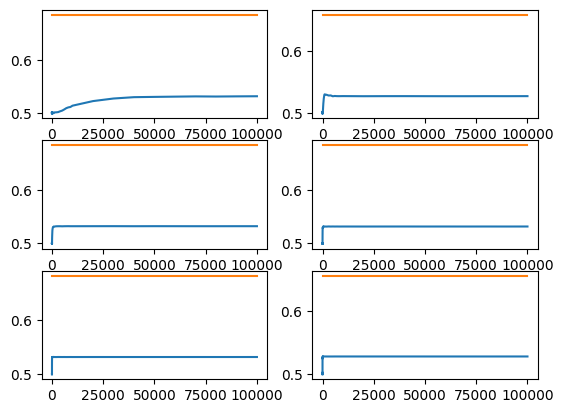

In [157]:
x = [0, 0, 1, 1, 2, 2]
y = [0, 1, 0, 1, 0, 1]
fig, axs = plt.subplots(3, 2)

for i,l2 in enumerate(l2_best):
    
    df = pd.DataFrame.from_dict(l2_reg_res[l2], orient='index')
    df = df.sort_index(ascending=True)
    axs[x[i],y[i]].plot(df.index, df['attack_acc_mean'], label=f'l2reg: {l2}')
    base = [base_data.loc[base_data['l2']==l2]['attack_acc'].item() for i in df.index]   
    axs[x[i],y[i]].plot(df.index, base, label=f'l2reg: {l2}')
#     axs[x[i],y[i]].fill_between(df.index, base, df['attack_acc_mean'], alpha=0.4,) #label='lam'+str(lam))
#     axs[x[i],y[i]].xscale('log')
# plt.legend(loc='lower right', bbox_to_anchor=(0.3, 0.5))
# plt.xlabel('epsilon')
# plt.ylabel('accuracy')   
# plt.xscale('log')
# plt.title('Membershin inference in output DP centralised with different l2 reg')
plt.savefig('figures/outputDP_l2_best_Membership_Inference_with_baseline.png')

In [ ]:
i = [1 2 3 4 5 6
x = [0, 0, 1, 1, 2, 2]
y = [0, 1, 0, 1, 0, 1]



# MI in output DP


In [319]:
path = 'out_dp'
tms_params = {}
tms = {}
for r,d,f in os.walk(path):
    for file in f:
        if ".json" in file:
            with open(path+'/'+file) as json_file:
                tms_params[file.replace('_params.json', '')] = json.load(json_file)
        if '.npy' in file:
            tms[file.replace('.npy', '')] = np.load(path+'/'+file)
            

In [322]:
df = pd.DataFrame.from_dict(tms_params, orient='index')

In [341]:
params = df.columns.drop(['test_acc', 'train_acc','attack_acc', 'attack_pre', 'attack_rec', 'attack_acc_mean', 'attack_acc_std',
       'attack_pre_mean', 'attack_pre_std', 'attack_rec_mean', 'outDP_train_acc', 'outDP_test_acc', 
       'attack_rec_std', 'outDP_epsilon'])
variant_params = {}
for i in params:
    if len(df[i].unique())>1:
        print(i, ': ', df[i].unique())
        variant_params[i] = df[i].unique()
    

lambda_ :  [1.e-08 1.e-02 1.e+01 5.e-04 1.e-03 1.e-01 1.e+00 5.e-02 1.e-07 1.e-06
 1.e-05 1.e-04 5.e-03]
L :  [10  1]


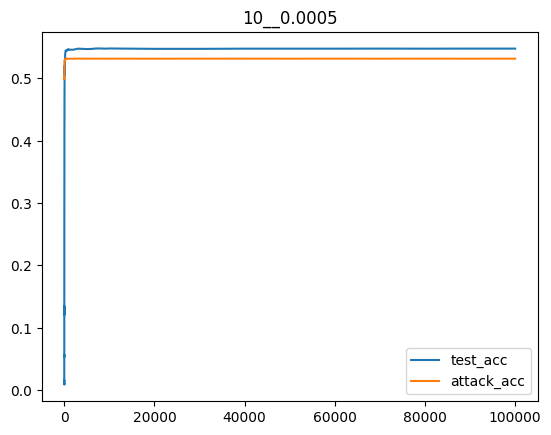

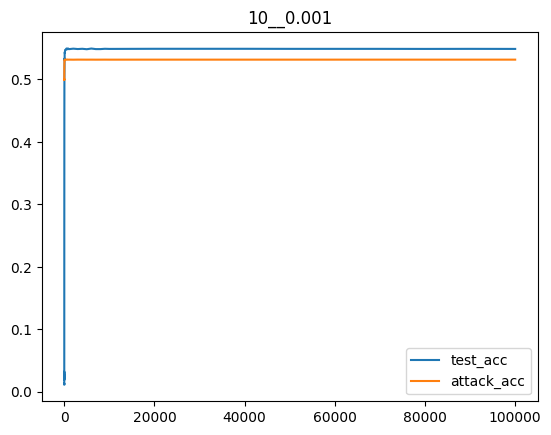

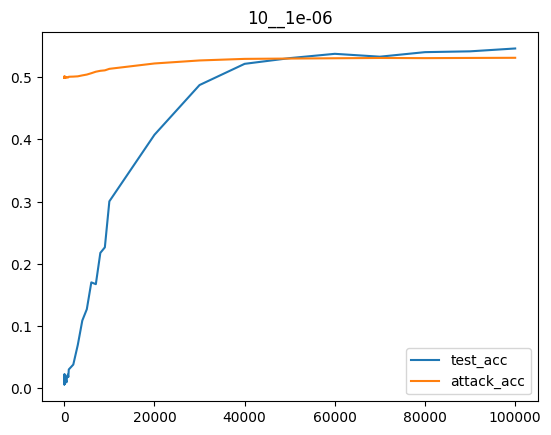

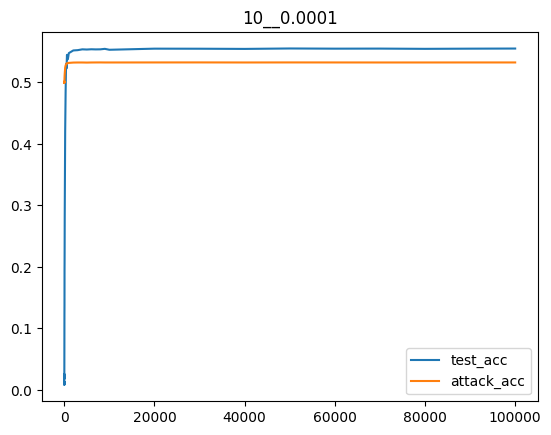

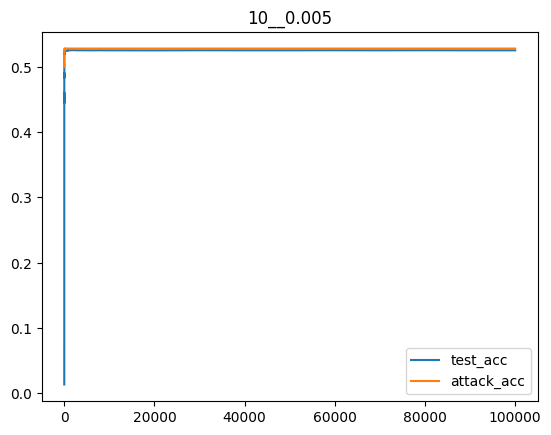

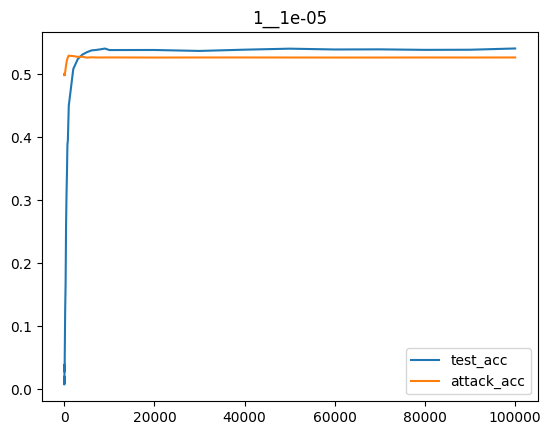

In [368]:
for L in variant_params['L']:
    for lam in variant_params['lambda_']:
        df_to_plot = df.loc[df['L']==L].loc[df['lambda_']==lam]
        if df_to_plot.shape[0]==0:
            continue
        if max(df_to_plot['outDP_test_acc']) > 0.5:
            plt.figure()
#             plt.title(df_to_plot.index[0])
            plt.title(str(L) + '__'+ str(lam))
            df_to_plot = df_to_plot.sort_values(by=['outDP_epsilon'])
            plt.plot(df_to_plot['outDP_epsilon'], df_to_plot['outDP_test_acc'], label='test_acc')
            plt.plot(df_to_plot['outDP_epsilon'], df_to_plot['attack_acc_mean'], label='attack_acc')
            plt.legend()

# MI DP SGD

In [275]:
path = 'tm'
tms_params = {}
tms = {}
for r,d,f in os.walk(path):
    for file in f:
        if "target_model_params.json" in file:
            with open(path+'/'+file) as json_file:
                tms_params[file.replace('_params.json', '')] = json.load(json_file)
        if 'target_model.npy' in file:
            tms[file.replace('.npy', '')] = np.load(path+'/'+file)
            

In [278]:
for i in tms:
    
    target_model = algo.LogisticRegression_DPSGD()
    target_model.n_classes = n_classes
    
    target_model.theta = tms[i]
    
    results = test_mi_attack(ams, target_model, x_target_train, y_target_train, x_target_test, y_target_test)
    tms_params[i].update(results)

In [280]:
df = pd.DataFrame.from_dict(tms_params, orient='index')

In [296]:
df.loc[df['DP']==True].loc[df['attack_acc_mean']>0.52]

,n_classes,alpha,max_iter,lambda_,tolerance,DP,L,C,epsilon,delta,...,test_acc,attack_acc_mean,attack_acc_std,attack_pre_mean,attack_pre_std,attack_rec_mean,attack_rec_std,attack_acc,attack_pre,attack_rec
rs42_lr0.001_iter500_reg1e-05_DPTrue_eps50000_L5_target_model,100,0.001,500,0.000010,0.00001,True,5,1,50000.0,0.00001,...,0.4733,0.523917,0.053816,0.581076,0.072967,0.109283,0.228844,NaN,NaN,NaN
rs42_lr0.001_iter500_reg0.0005_DPTrue_eps50000_L5_target_model,100,0.001,500,0.000500,0.00001,True,5,1,50000.0,0.00001,...,0.4681,0.523833,0.053630,0.581828,0.073707,0.106633,0.222922,NaN,NaN,NaN
rs42_lr0.001_iter500_reg0.0005_DPTrue_eps100000_L5_target_model,100,0.001,500,0.000500,0.00001,True,5,1,100000.0,0.00001,...,0.4652,0.523750,0.053444,0.581699,0.073578,0.106667,0.222996,NaN,NaN,NaN
rs42_lr0.001_iter500_reg0.001_DPTrue_eps10000_L5_target_model,100,0.001,500,0.001000,0.00001,True,5,1,10000.0,0.00001,...,0.4516,0.522100,0.049754,0.581036,0.072928,0.101583,0.211637,0.51175,0.722960,0.0381
rs42_lr0.005_iter500_reg0.001_DPTrue_eps100000_L5_target_model,100,0.005,500,0.001000,0.00001,True,5,1,100000.0,0.00001,...,0.4409,0.526758,0.060170,0.575037,0.068245,0.149450,0.318622,NaN,NaN,NaN
rs42_lr0.001_iter500_reg0.001_DPTrue_eps1000_L5_target_model,100,0.001,500,0.001000,0.00001,True,5,1,1000.0,0.00001,...,0.4319,0.520633,0.046475,0.579589,0.071597,0.099450,0.206870,0.51215,0.712785,0.0407
rs42_lr0.001_iter500_reg0.001_DPTrue_eps100000_L5_target_model,100,0.001,500,0.001000,0.00001,True,5,1,100000.0,0.00001,...,0.4637,0.522958,0.051673,0.581494,0.073375,0.103917,0.216851,NaN,NaN,NaN
rs42_lr0.001_iter500_reg0.0005_DPTrue_eps1000_L5_target_model,100,0.001,500,0.000500,0.00001,True,5,1,1000.0,0.00001,...,0.4328,0.520900,0.047071,0.579210,0.071268,0.101850,0.212232,NaN,NaN,NaN
rs42_lr0.001_iter500_reg0.0001_DPTrue_eps10000_L5_target_model,100,0.001,500,0.000100,0.00001,True,5,1,10000.0,0.00001,...,0.4509,0.522967,0.051692,0.580509,0.072429,0.106950,0.223629,NaN,NaN,NaN
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps10000_L3_target_model,100,0.001,500,0.000001,0.00001,True,3,1,10000.0,0.00001,...,0.4273,0.522583,0.050835,0.574108,0.067728,0.132167,0.279988,0.55910,0.747695,0.1784


# MI in Fl


In [195]:
path = 'fl'
params = {}
results = {}
models = {}
for r,d,f in os.walk(path):
    for file in f:
        if "params.json" in file:
            with open(r+'/'+file) as json_file:
                params[r] = json.load(json_file)
        elif "results.csv" in file:
            results[r] = pd.read_csv(r+'/'+file)
            it = []
            client = []
            for k in results[r]['Unnamed: 0']:
                it.append(k[k.find('i')+1:k.find('_')])
                client.append(k[k.find('_')+1:])
            results[r]['it'] = it
            results[r]['client'] = client
        elif '.npy' in file:
            if r not in models:
                models[r] = {}
            models[r][file] = np.load(r+'/'+file)



In [260]:
# file = 'fl/rs42_ncl2_fiter5_lr0.01_iter50_reg0.005_DPFalse'
# file = 'fl/rs42_ncl4_fiter5_lr0.01_iter50_reg1e-05_DPFalse'
file = 'fl/rs42_ncl8_fiter5_lr0.001_iter300_reg1e-05_DPFalse'

nodes = int(file[file.find('_ncl')+4:file.find('_fiter')])
rand_seed = int(file[file.find('fl/rs')+5:file.find('_ncl')])

In [261]:
# models from first iteration
fl_models = {}
for i in models[file]:
    if 'i0_' in i:
        fl_models[i[i.find('i0_c')+4:i.find('.npy')]] = models[file][i]

In [262]:
x_target_train = np.load('data/rs'+str(rand_seed)+'_x_target_train.npy')
y_target_train = np.load('data/rs'+str(rand_seed)+'_y_target_train.npy')
x_target_test = np.load('data/rs'+str(rand_seed)+'_x_target_test.npy')
y_target_test = np.load('data/rs'+str(rand_seed)+'_y_target_test.npy')
n_classes = len(np.unique(y_target_train))

number_of_clients = nodes
data_per_client = int(x_target_train.shape[0]/number_of_clients)

clients = {}
for i in range(number_of_clients):
    clients[i] = algo.LogisticRegression_DPSGD()
    clients[i].n_classes = n_classes
    
    clients[i].x = x_target_train[i*data_per_client:(i+1)*data_per_client]
    clients[i].y = y_target_train[i*data_per_client:(i+1)*data_per_client]
    clients[i].theta = fl_models[str(i)]

clients['g'] = algo.LogisticRegression_DPSGD()
clients['g'].n_classes = n_classes
clients['g'].theta = fl_models['g']
clients['g'].x = x_target_train
clients['g'].y = y_target_train

In [263]:
results = {}
for i in clients:
#     attack.mi_attack_test(clients[i], a_model, x_target_train, y_target_train, x_target_test, y_target_test)
    results[i] = test_mi_attack(ams, clients[i], clients[i].x, clients[i].y, x_target_test, y_target_test)

In [264]:
results

{0: {'attack_acc_mean': 0.8910518518518519,
  'attack_acc_std': 0.019347286011079507,
  'attack_pre_mean': 0.12887480893856348,
  'attack_pre_std': 0.2247570112117821,
  'attack_rec_mean': 0.1636,
  'attack_rec_std': 0.3554892966039906},
 1: {'attack_acc_mean': 0.8923703703703705,
  'attack_acc_std': 0.021520195000671836,
  'attack_pre_mean': 0.14358680674134058,
  'attack_pre_std': 0.23247423509235346,
  'attack_rec_mean': 0.16466666666666666,
  'attack_rec_std': 0.3529225536699077},
 2: {'attack_acc_mean': 0.892725925925926,
  'attack_acc_std': 0.02178439304918229,
  'attack_pre_mean': 0.27626076164377017,
  'attack_pre_std': 0.17979309640432037,
  'attack_rec_mean': 0.16533333333333333,
  'attack_rec_std': 0.35015293166780076},
 3: {'attack_acc_mean': 0.8929777777777779,
  'attack_acc_std': 0.02254468265577016,
  'attack_pre_mean': 0.2738904422528505,
  'attack_pre_std': 0.1855714981246906,
  'attack_rec_mean': 0.1650666666666667,
  'attack_rec_std': 0.3513210624043041},
 4: {'attac

In [ ]:
plt.plot([out_eps[0],out_eps[-1]], [0.655836, 0.655836], label='noDP centr MI baseline')

data = pd.DataFrame.from_dict(results, orient='index')
for i, m in enumerate(fl_noised_eps[eps]):
    plt.plot(data.index, data[i], label=f'client {m}')

plt.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=8)
plt.xlabel('epsilon')
plt.ylabel('accuracy')   
plt.title(f'Output DP Federated {nodes} nodes')
plt.savefig(f'figures/fl/outputDP_{nodes}nodes.png')
data.to_csv(f'figures/fl/outputDP_{nodes}nodes.csv')


In [224]:
target_model.theta.shape

(601, 100)

In [225]:
clients[i].theta.shape

(601, 100)